In [ ]:
import pandas as pd
import numpy as np
import keras
from keras import layers

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA 
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# REPRODUCIBILITY
SEED = 42

from numpy.random import seed
seed(1)
import tensorflow as tf
tf.random.set_seed(2)

# PART 1: Dimensionality Reduction

Upload the labels.csv and processed_counts.csv files to colab or your local workspace.

This data associates a cell barcode, such as "AAAGCCTGGCTAAC-1", to a certain cell type label, such as "CD14+ Monocyte". For each cell barcode, there are also log RNA seq counts of 765 different genes, such as HES4.

label.csv stores the association between a cell barcode and a cell type label.

processed_counts.csv stores the normalized log read counts for each cell, where each row represents a single cell, and each column represents a gene.

## Data Preprocessing and Splitting

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# %cd '/content/drive/My Drive/BioE 145 Final Project'
%cd '/content/drive/My Drive/Classes/BioE 145/BioE 145 Final Project'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Classes/BioE 145/BioE 145 Final Project


In [ ]:
labels_pd = pd.read_csv("labels.csv")
counts_pd = pd.read_csv("processed_counts.csv")

Shuffle your data. Make sure your labels and the counts are shuffled together.

Split into train and test sets (80:20 split)

In [ ]:
# join datasets on the index columns
counts_pd = counts_pd.rename(columns={'Unnamed: 0': 'index'})
joint_data = counts_pd.merge(labels_pd, on='index')

X = joint_data.drop(['index', 'bulk_labels'], axis=1)
y = joint_data['bulk_labels']

 ### Splitting

We decided not to split the dataset into train and test because we did not use the Autoencoder outputs in the downstream classification task. Thus, we will get more representative encodings if we train the Autoencoder on the entire dataset.

Create a fully connected neural network for your autoencoder. Your latent space can be of any size less than or equal to 64. Too large may result in a poor visualization, and too small may result in high loss. 32 is a good starting point.

Consider using more than 1 hidden layer, and a sparcity constraint (l1 regularization).

Have an encoder model which is a model of only the layers for the encoding.

In [ ]:
from keras import regularizers

input_dim = X.shape[1]

input = keras.Input(shape=(input_dim,))

encoded = layers.Dense(256, activation='relu')(input)
encoded = layers.Dense(128, activation='relu',
                       activity_regularizer=regularizers.l1(10e-7))(encoded)
encoded = layers.Dense(64, activation='relu')(encoded)
encoded_32 = layers.Dense(32, activation='relu')(encoded)

decoded = layers.Dense(64, activation='relu')(encoded_32)
decoded = layers.Dense(128, activation='relu',
                       activity_regularizer=regularizers.l1(10e-7))(decoded)
decoded = layers.Dense(256, activation='relu')(decoded)
decoded = layers.Dense(input_dim, activation='relu')(decoded)

Train your autoencoding using MSE loss.

Finally, identify the parameters which don't overfit, and use the same model architecture and train on all of the data together.

With a latent space size of 32, aim for 0.9 MSE loss on your test set, 0.95 with regularization. You will not be graded strictly on a loss cutoff.

In [ ]:
autoencoder = keras.Model(input, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.fit(X, X,
                epochs=500,
                batch_size=256,
                shuffle=True,
                validation_data=(X, X)) # Cross Validation

Epoch 1/500
3/3 [==============================] - 2s 297ms/step - loss: 1.0109 - val_loss: 1.0015
Epoch 2/500
3/3 [==============================] - 0s 27ms/step - loss: 1.0002 - val_loss: 1.0003
Epoch 3/500
3/3 [==============================] - 0s 23ms/step - loss: 0.9979 - val_loss: 0.9975
Epoch 4/500
3/3 [==============================] - 0s 24ms/step - loss: 0.9947 - val_loss: 0.9915
Epoch 5/500
3/3 [==============================] - 0s 25ms/step - loss: 0.9886 - val_loss: 0.9844
Epoch 6/500
3/3 [==============================] - 0s 24ms/step - loss: 0.9875 - val_loss: 0.9758
Epoch 7/500
3/3 [==============================] - 0s 23ms/step - loss: 0.9706 - val_loss: 0.9639
Epoch 8/500
3/3 [==============================] - 0s 24ms/step - loss: 0.9651 - val_loss: 0.9516
Epoch 9/500
3/3 [==============================] - 0s 24ms/step - loss: 0.9508 - val_loss: 0.9410
Epoch 10/500
3/3 [==============================] - 0s 25ms/step - loss: 0.9449 - val_loss: 0.9317
Epoch 11/500
3/3 [

In [ ]:
# encoder_64 = keras.Model(input, encoded_64)
encoder_32 = keras.Model(input, encoded_32)
encoder_32.predict(X).shape

(700, 32)

#Raw Dataset Analysis

## PCA

In [ ]:
def plot_pca(X, y, experiment_name = 'Initial Data'):
  pca = PCA(n_components=2, random_state=SEED)
  X_train_pca = pca.fit_transform(X)

  pc1_explained_var = pca.explained_variance_ratio_[0]
  pc2_explained_var = pca.explained_variance_ratio_[1]

  X_train_pca_df = pd.DataFrame(X_train_pca)
  X_train_pca_df = X_train_pca_df.rename(columns={0: 'PC1',
                                                  1: 'PC2'})
  X_train_pca_df['bulk_labels'] = y

  plt.figure(figsize=(10, 6))
  sns.scatterplot(x='PC1', y='PC2', hue='bulk_labels', data=X_train_pca_df, s=40)
  plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
  plt.xlabel(f'PC1 ({np.round(100 * pc1_explained_var, 2)}%)', fontsize=20)
  plt.ylabel(f'PC2 ({np.round(100 * pc2_explained_var, 2)}%)', fontsize=15)
  plt.title(f'PCA applied to {experiment_name}', fontsize=15)
  plt.tight_layout();


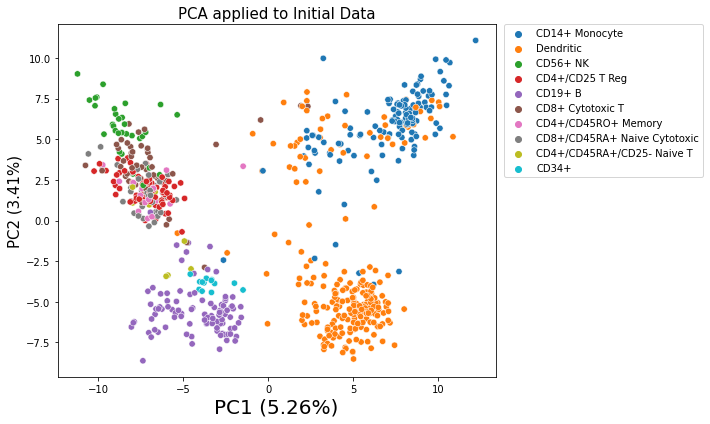

In [ ]:
plot_pca(X, y)

## t-SNE

In [ ]:
def plot_tSNE(X, y, perplexity = 100, experiment_name = 'Initial Dataset'):
  X_tsne_embedded = TSNE(n_components=2, 
                       perplexity= perplexity,
                       method='barnes_hut',
                       random_state=SEED).fit_transform(X)
  X_train_tsne_df = pd.DataFrame(X_tsne_embedded)
  X_train_tsne_df['bulk_labels'] = y
  
  plt.figure(figsize=(10, 6))
  sns.scatterplot(x=0, y=1, hue='bulk_labels', data=X_train_tsne_df, s=40)
  plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
  plt.title(f't-SNE applied to {experiment_name}', fontsize=20)
  plt.ylabel('')
  plt.xlabel('')
  plt.tight_layout();

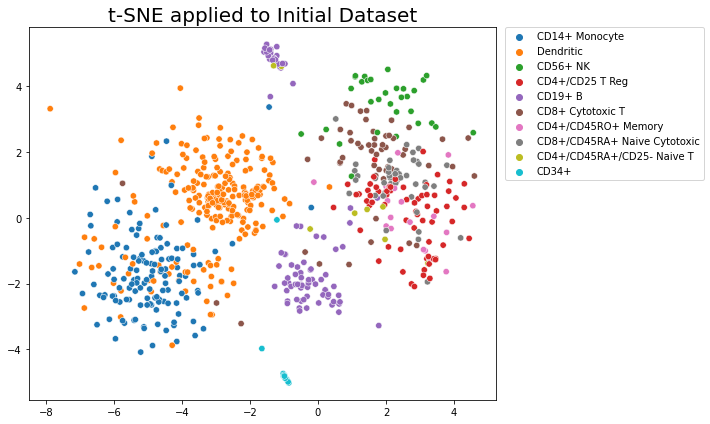

In [ ]:
plot_tSNE(X, y, perplexity=100)

## Latent Space

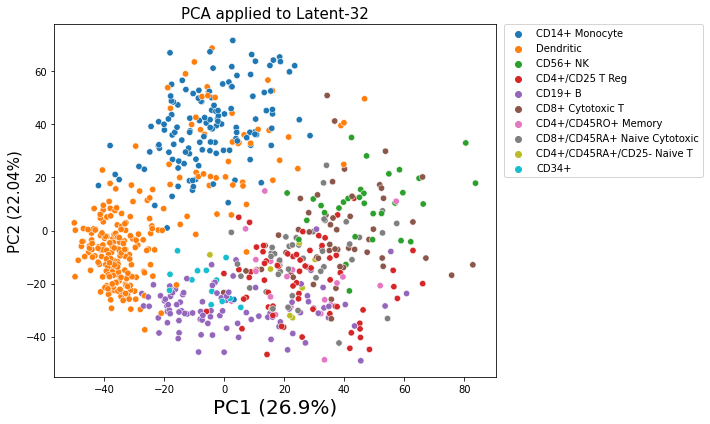

In [ ]:
#Using PCA on latent space
latent_32 = encoder_32.predict(X)

plot_pca(latent_32, y, "Latent-32")

Compare the results of PCA, t-SNE, and your autoencoder as ways to visualize the data.

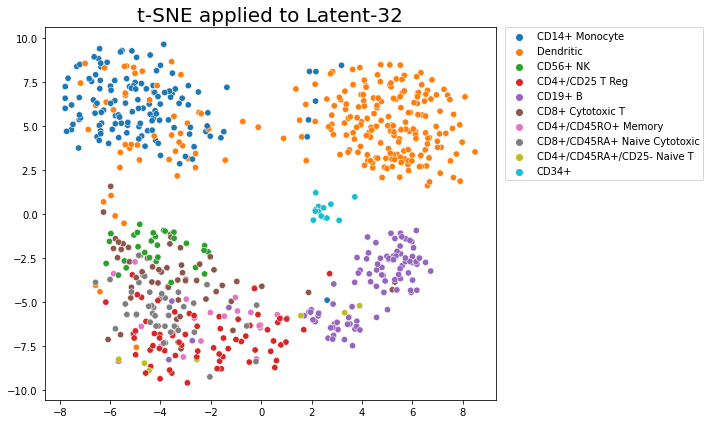

In [ ]:
# t-SNE on the latent space
plot_tSNE(latent_32, y, perplexity=100, experiment_name = 'Latent-32') 